In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models, regularizers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from tensorflow.keras.models import load_model

In [3]:
train_data_dir= "/kaggle/input/brain-tumor-mri-dataset/Training"
test_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [4]:
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [52]:
X_train, X_valid = train_test_split(train_df,  train_size=0.8 , shuffle= True, random_state= 123)

In [53]:
X_train.head()

,filepaths,labels
2730,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
4748,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
4811,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
3789,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
1672,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor


In [84]:
train_data_dir= "/kaggle/input/brain-tumor-mri-dataset/Training"
test_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

IMAGE_SIZE =(256,256)
BATCH_SIZE = 32

# Training and validation datasets
X_train = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",  # Specify the subset
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 128x128
    batch_size=BATCH_SIZE  # Batch size
)


X_val = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

X_test = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    shuffle = False,
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 128x128
    batch_size=BATCH_SIZE  # Batch size
)

class_names = X_test.class_names

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [19]:
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf

# Define the number of classes
num_classes = len(class_names)  # Replace with the actual number of classes

# Function to one-hot encode the labels
def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=num_classes)

# Assuming X_train_normalized and X_val_normalized are pre-loaded datasets
X_train_encoded = X_train_normalized.map(one_hot_encode)
X_val_encoded = X_val_normalized.map(one_hot_encode)

# Get the input shape from one batch of the dataset
for image_batch, label_batch in X_train_encoded.take(1):
    input_shape = image_batch.shape[1:]  # (Height, Width, Channels)

def load_model(input_shape):
    # Load the VGG16 model with pre-trained weights
    model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    return model

model = load_model(input_shape)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def set_nontrainable_layers(model):

    # Set the first layers to be untrainable
    model.trainable = False

    return model

model = set_nontrainable_layers(model)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(4, activation='softmax')


    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

In [39]:
model = add_last_layers(model)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ ?                      │    31,100,691 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,100,691 (118.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 31,100,691 (118.64 MB)

In [ ]:
from tensorflow.keras import optimizers

def build_model():
    model = load_model(input_shape)
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model


In [41]:
model = build_model()
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [42]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [85]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

# Training and validation datasets
X_train = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",  # Specify the subset
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 256x256
    batch_size=BATCH_SIZE  # Batch size
)

X_val = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

X_test = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    shuffle=False,
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 256x256
    batch_size=BATCH_SIZE  # Batch size
)

# Apply preprocess_input to datasets
def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (preprocess_input(x), y))

X_train_pre = preprocess_dataset(X_train)
X_val_pre = preprocess_dataset(X_val)
X_test_pre = preprocess_dataset(X_test)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [86]:
# One-hot encode labels
num_classes = len(class_names)  # Get the number of classes (directories)

def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=num_classes)

X_train_encoded = X_train_pre.map(one_hot_encode)
X_val_encoded = X_val_pre.map(one_hot_encode)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

# Build the model
model = build_model()  # Ensure this is defined elsewhere and includes accuracy metrics

# Define EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy',  # Track validation accuracy
    mode='max',  # Maximize accuracy
    patience=5,  # Stop after 5 epochs of no improvement
    verbose=1,  # Print progress
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model
history = model.fit(
    X_train_encoded,  # Training dataset
    validation_data=X_val_encoded,  # Validation dataset
    epochs=50,  # Number of epochs
    callbacks=[es]  # Early stopping callback
)

Epoch 1/50


I0000 00:00:1733983578.686360      98 service.cc:145] XLA service 0x7d8e9c007ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733983578.686433      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733983578.686438      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/143 ━━━━━━━━━━━━━━━━━━━━ 54:45 23s/step - accuracy: 0.2500 - loss: 13.3787

I0000 00:00:1733983599.833382      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 456ms/step - accuracy: 0.7791 - loss: 2.9819 - val_accuracy: 0.9273 - val_loss: 0.4130
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 251ms/step - accuracy: 0.9709 - loss: 0.1499 - val_accuracy: 0.9518 - val_loss: 0.3235
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.9787 - loss: 0.1090 - val_accuracy: 0.9370 - val_loss: 0.5512
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 222ms/step - accuracy: 0.9889 - loss: 0.0385 - val_accuracy: 0.9580 - val_loss: 0.2932
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.9955 - loss: 0.0090 - val_accuracy: 0.9492 - val_loss: 0.3186
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.9969 - loss: 0.0161 - val_accuracy: 0.9475 - val_loss: 0.3819
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.9919 - loss: 0.0315 - val_accuracy: 0.9475 - val_loss: 0.4239
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.9919 - loss: 0.0548 - val

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

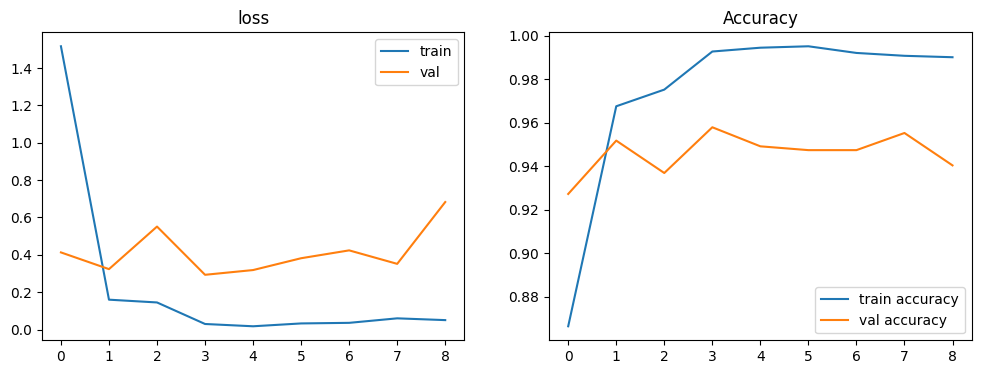

In [47]:
plot_history(history)

In [87]:
# One-hot encode the test dataset
X_test_encoded = X_test_pre.map(one_hot_encode)

# Evaluate the model
res_vgg = model.evaluate(X_test_encoded)

# Extract test accuracy (last metric from evaluate)
test_accuracy_vgg = res_vgg[-1]

# Print the test accuracy for VGG
print(f"test_accuracy_vgg = {round(test_accuracy_vgg * 100, 2)}%")

# Calculate chance level
print(f'Chance level: {1. / num_classes * 100:.1f}%')

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.9329 - loss: 0.4864
test_accuracy_vgg = 95.27%
Chance level: 25.0%


In [88]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [89]:
# Find the index of the best validation accuracy
best_epoch_index = np.argmax(history.history['val_accuracy'])

print(f"Best epoch (index) based on validation accuracy: {best_epoch_index}")

Best epoch (index) based on validation accuracy: 3


In [70]:
# Optionally, print specific metrics like accuracy, loss, and AUC
print("\nSpecific Metrics (Training & Validation):")
print(f"Training Accuracy: {history.history['accuracy'][best_epoch_index]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch_index]}")
print(f"Training Loss: {history.history['loss'][best_epoch_index]}")
print(f"Validation Loss: {history.history['val_loss'][best_epoch_index]}")
#print(f"Training Precision: {history.history['precision'][best_epoch_index]}")
#print(f"Validation Precision: {history.history['val_precision'][best_epoch_index]}")
#print(f"Training Recall: {history.history['recall'][best_epoch_index]}")
#print(f"Validation Recall: {history.history['val_recall'][best_epoch_index]}")
#print(f"Training AUC: {history.history['auc'][best_epoch_index]}")
#print(f"Validation AUC: {history.history['val_auc'][best_epoch_index]}")


Specific Metrics (Training & Validation):
Training Accuracy: 0.992779016494751
Validation Accuracy: 0.9579684734344482
Training Loss: 0.029947571456432343
Validation Loss: 0.29320967197418213


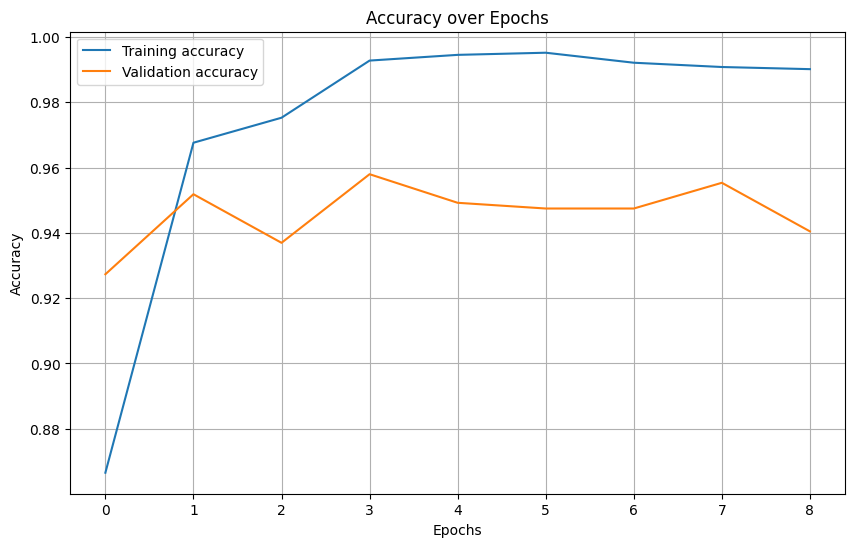

KeyError: 'auc'

<Figure size 1000x600 with 0 Axes>

In [90]:
# Define the metrics to plot
metrics = ['accuracy', 'auc', 'loss', 'precision', 'recall']

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [91]:
# Fetch the true labels from the test dataset
y_test = []
for images, labels in X_test:
    y_test.extend(labels.numpy())  # Add the labels for this batch
y_test = np.array(y_test)

In [92]:
X_test.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step


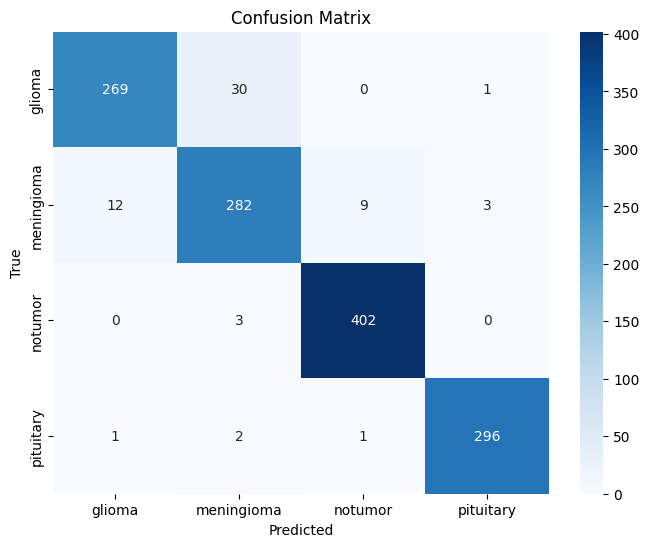

In [93]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve class names
class_names = X_test.class_names  # This contains the list of class names in order

# Get the predicted probabilities for the test set
y_pred_proba = model.predict(X_test_encoded, verbose=1)

# Convert predicted probabilities to predicted class labels
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Calculate metrics like the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


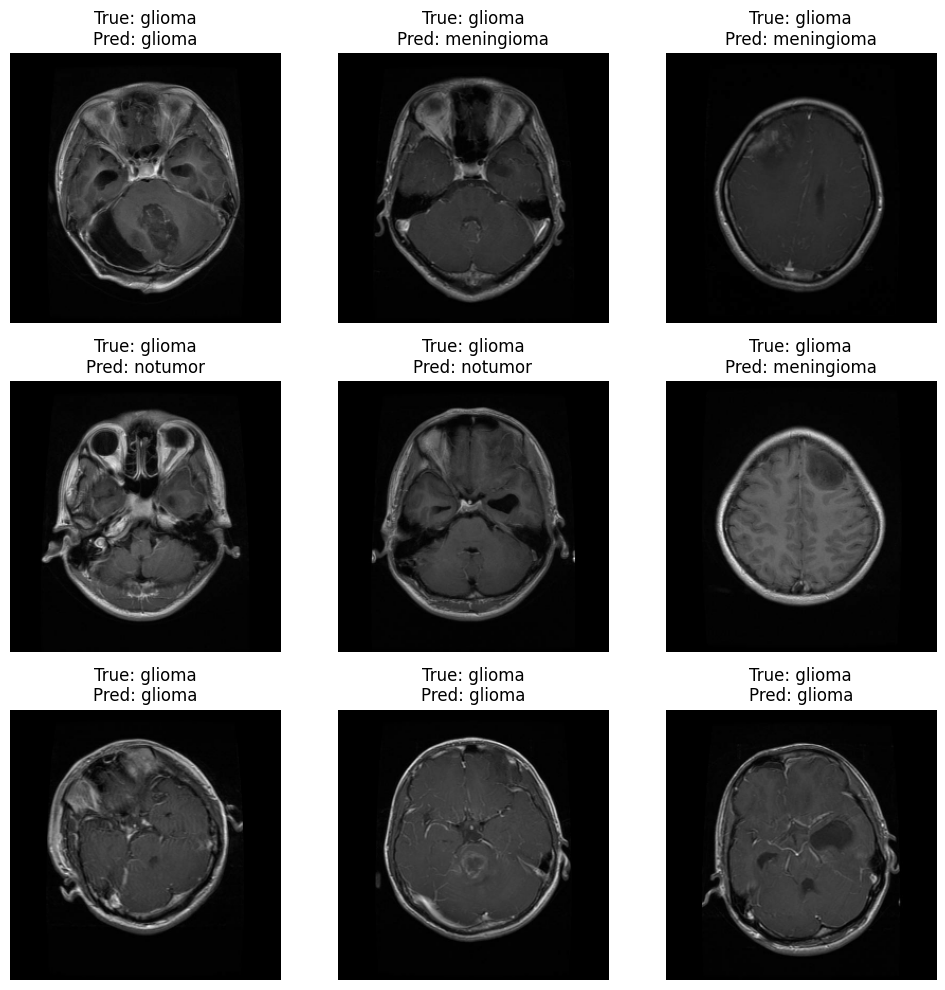

In [94]:
# Fetch a batch of images and labels
batch = next(iter(X_test))
test_images, test_labels = batch

# Predict on the batch
batch_predictions = model.predict(test_images)
batch_predicted_classes = np.argmax(batch_predictions, axis=1)

# Visualize the predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))  # Convert tensor to uint8 array
    true_label = class_names[np.argmax(test_labels[i].numpy())]
    predicted_label = class_names[batch_predicted_classes[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()